# Data queries - Quick start

Deep Search parses and interprets large collections of documents quickly and concurrently.
These collections are stored and indexed such that you can search and retrieve any document according to their contents.

Depending if the user is querying public or private data, the commands will look a bit different.
In this example we first showcase both:

1. Query public data
    1. [Inspect Deep Search data](#Inspect-Deep-Search-data)
    2. [Search documents](#Search-documents)
3. [Query private data](#Query-private-data)


### Access required

The content of this notebook requires access to Deep Search capabilities which are not
available on the public access system.

[Contact us](https://ds4sd.github.io) if you are interested in exploring
these Deep Search capabilities.

### Set notebook parameters

In [1]:
from dsnotebooks.settings import CollOptionalNotebookSettings

# notebook settings auto-loaded from .env / env vars
notebook_settings = CollOptionalNotebookSettings()

PROFILE_NAME = notebook_settings.profile  # the profile to use

# The following settings are required only for running the private data part of this example
PROJ_KEY = (
    notebook_settings.proj_key
)  # the project containing the private data to query
INDEX_KEY = (
    notebook_settings.index_key
)  # the data collection containing the private data to query

### Import example dependencies

In [7]:
# Import standard dependenices
from copy import deepcopy
from datetime import datetime
import pandas as pd
from numerize.numerize import numerize
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

# IPython utilities
from IPython.display import display, HTML

# Import the deepsearch-toolkit
import deepsearch as ds
from deepsearch.cps.client.components.elastic import (
    ElasticDataCollectionSource,
)  # For public collections
from deepsearch.cps.client.components.data_indices import (
    ElasticProjectDataCollectionSource,
)  # For private collections
from deepsearch.cps.queries import DataQuery

### Connect to Deep Search

In [3]:
api = ds.CpsApi.from_env(profile_name=PROFILE_NAME)

---

## Inspect Deep Search data

In this section we will inspect the different data collections on Deep Search and we will perform soma initial searches.

Explanation of the columns
- **Name**: The name of the data collection
- **Type**: Type of content in the data collection (see below)
- **Date**: Date of the last update on the data
- **Num entries**: Number of entries in the data collection
- **Coords**: Coordinates needed in the Deep Search Toolkit to query a specific data collection


Type of data collections
- **Document**: A collection of documents. These are either PDF documents already converted via the Deep Search document conversion, or data sources which can be mapped to the same format, e.g. the USPTO patents are obtained as sourced as XML
- **Record**: A collection of DB records in a structure database. For example, the content of PubChem is made available in this format. 

In [4]:
# Fetch list of all data collections
collections = api.elastic.list()
collections.sort(key=lambda c: c.name.lower())

In [8]:
# Visualize summary table
results = [
    {
        "Name": c.name,
        "Type": c.metadata.type,
        "Num entries": numerize(c.documents),
        "Date": datetime.fromisoformat(c.metadata.created).strftime("%Y-%m-%d"),
        "Coords": f"{c.source.elastic_id}/{c.source.index_key}",
    }
    for c in collections
]
display(pd.DataFrame(results))

,Name,Type,Num entries,Date,Coords
0,AAAI,Document,16.02K,2023-08-29,default/aaai
1,ACL Anthology,Document,55.28K,2023-08-22,default/acl
2,Annual Reports,Document,107.38K,2024-04-15,default/annual-report
3,arXiv abstracts,Document,2.48M,2024-05-22,default/arxiv-abstract
4,arXiv category taxonomy,Record,155,2024-05-22,default/arxiv-category
...,...,...,...,...,...
56,UMLS,Record,2.69M,2023-01-03,default/umls
57,UniProt,Record,567.48K,2023-01-03,default/uniprot
58,USPTO patents for NER,Document,2.64K,2023-03-20,default/uspto-for-ner
59,VHDL articles,Document,215,2024-04-23,default/vhdl


### Search among data collections

In the following section we will count how many results we obtain in each data collection.

⚠️ To just count, pass an empty list as `source` argument in the `DataQuery` class to avoid unnecessary data transfers.

In [9]:
# Input query
search_query = 'main-text.text:(("power conversion efficiency" OR PCE) AND organ*)'

# Iterate through the data collections
results = []
for c in (pbar := tqdm(collections)):
    pbar.set_description(f"Querying {c.name}")

    # Search only on document collections
    if c.metadata.type != "Document":
        continue

    # Execute the query
    query = DataQuery(search_query, source=[], limit=0, coordinates=c.source)
    query_results = api.queries.run(query)
    results.append({"name": c.name, "matches": query_results.outputs["data_count"]})

# Sort and display results
results.sort(reverse=True, key=lambda r: r["matches"])
display(pd.DataFrame(results))

  0%|          | 0/61 [00:00<?, ?it/s]

,name,matches
0,Patents from USPTO,11755
1,Semantic Scholar Academic Graph,11648
2,PubMed Central,6050
3,Patents from EPO,2929
4,arXiv full documents,2031
5,News,1478
6,PLOS,570
7,Wikipedia,477
8,BioRxiv,447
9,Patents from KIPO,212


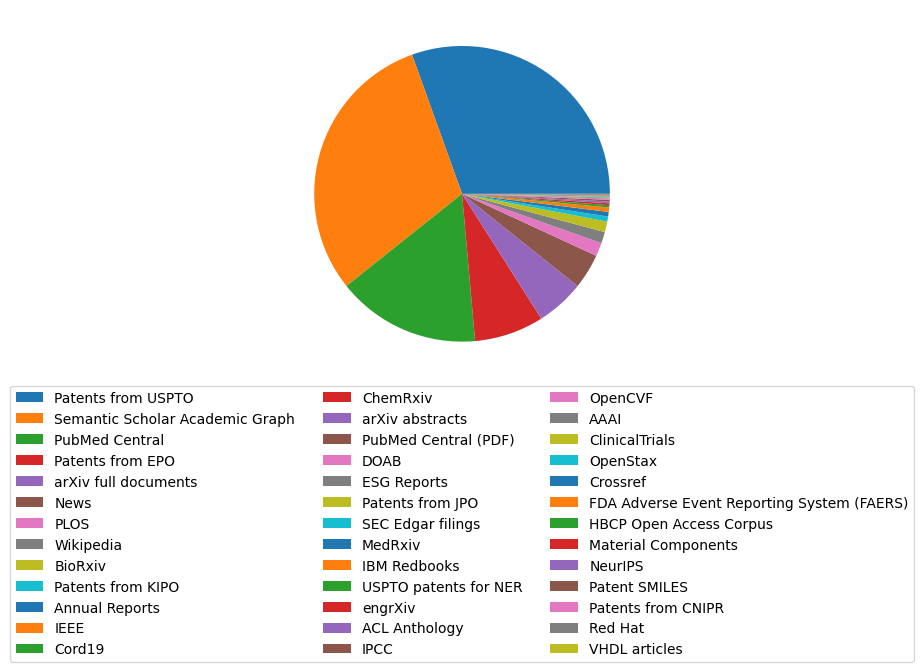

In [10]:
# Plot the distribution of results among data collections

x = [r["name"] for r in results]
y = [r["matches"] for r in results]
plt.pie(y, labels=x, labeldistance=None)
plt.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 0))

---

## Search documents

In this section we search for documents in the arXiv.org data collection matching the input query.
For each matched document we return the title, authors as well as the link to the original document on arXix.org 


This example will demonstrate
1. How to address a specific data collection
2. How to choose which component of the documents should be returned
3. How to iterate through the complete data collection by fetching `page_size=50` results at the time


In [8]:
# Input query
search_query = 'main-text.text:(("power conversion efficiency" OR PCE) AND organ*)'
data_collection = ElasticDataCollectionSource(
    elastic_id="default", index_key="arxiv-abstract"
)
page_size = 50

# Prepare the data query
query = DataQuery(
    search_query,  # The search query to be executed
    source=[
        "description.title",
        "description.authors",
        "identifiers",
    ],  # Which fields of documents we want to fetch
    limit=page_size,  # The size of each request page
    coordinates=data_collection,  # The data collection to be queries
)


# [Optional] Compute the number of total results matched. This can be used to monitor the pagination progress.
count_query = deepcopy(query)
count_query.paginated_task.parameters["limit"] = 0
count_results = api.queries.run(count_query)
expected_total = count_results.outputs["data_count"]
expected_pages = (
    expected_total + page_size - 1
) // page_size  # this is simply a ceiling formula


# Iterate through all results by fetching `page_size` results at the same time
all_results = []
cursor = api.queries.run_paginated_query(query)
for result_page in tqdm(cursor, total=expected_pages):
    # Iterate through the results of a single page, and add to the total list
    for row in result_page.outputs["data_outputs"]:
        # Process custom identifiers links
        links = {"arxiv": None, "doi": None}
        identifiers = {"arxiv": None, "doi": None}
        for ids in row["_source"].get("identifiers", []):
            if ids["type"] == "arxivid":
                identifiers["arxiv"] = ids["value"]
                links["arxiv"] = f'https://arxiv.org/abs/{ids["value"]}'
            if ids["type"] == "doi":
                identifiers["doi"] = ids["value"]
                links["doi"] = f'https://doi.org/{ids["value"]}'

        # Add row to results table
        all_results.append(
            {
                "Title": row["_source"]["description"]["title"],
                "Authors": ", ".join(
                    [
                        author["name"]
                        for author in row["_source"]["description"]["authors"]
                    ]
                ),
                "arXiv": identifiers["arxiv"],
                "arXiv URL": links["arxiv"],
                "DOI": identifiers["doi"],
                "DOI URL": links["doi"],
            }
        )

print(f"Finished fetching all data. Total is {len(all_results)} records.")

  0%|          | 0/2 [00:00<?, ?it/s]

Finished fetching all data. Total is 70 records.


In [9]:
# Visualize the table with all results
df = pd.json_normalize(all_results)
display(HTML(df.head().to_html(render_links=True)))

,Title,Authors,arXiv,arXiv URL,DOI,DOI URL
0,How Good Can 2D Excitonic Solar Cells Be?,"Zekun Hu, Da Lin, Jason Lynch, Kevin Xu, Deep Jariwala",2302.04788,https://arxiv.org/abs/2302.04788,None,None
1,The role of charge recombination to spin-triplet excitons in\n non-fullerene acceptor organic solar cells,"Alexander J. Gillett, Alberto Privitera, Rishat Dilmurat, Akchheta Karki, Deping Qian, Anton Pershin, Giacomo Londi, William K. Myers, Jaewon Lee, Jun Yuan, Seo-Jin Ko, Moritz K. Riede, Feng Gao, Guillermo C. Bazan, Akshay Rao, Thuc-Quyen Nguyen, David Beljonne, Richard H. Friend",2010.10978,https://arxiv.org/abs/2010.10978,10.1038/s41586-021-03840-5,https://doi.org/10.1038/s41586-021-03840-5
2,Design of Lead-Free Inorganic Halide Perovskites for Solar Cells via\n Cation-Transmutation,"Xin-Gang Zhao, Ji-Hui Yang, Yuhao Fu, Dongwen Yang, Qiaoling Xu, Liping Yu, Su-Huai Wei, Lijun Zhang",1705.10014,https://arxiv.org/abs/1705.10014,10.1021/jacs.6b09645,https://doi.org/10.1021/jacs.6b09645
3,On the Absence of Triplet Exciton Loss Pathways in Non-Fullerene\n Acceptor based Organic Solar Cells,"Maria S. Kotova, Giacomo Londi, Johannes Junker, Stefanie Dietz, Alberto Privitera, Kristofer Tvingstedt, David Beljonne, Andreas Sperlich, Vladimir Dyakonov",2002.07531,https://arxiv.org/abs/2002.07531,10.1039/D0MH00286K,https://doi.org/10.1039/D0MH00286K
4,Correlated In-Situ Low-Frequency Noise and Impedance Spectroscopy Reveal\n Recombination Dynamics in Organic Solar Cells using Fullerene and\n Non-Fullerene Acceptors,"Kyle A. Luck, Vinod K. Sangwan, Patrick E. Hartnett, Heather N. Arnold, Michael R. Wasielewski, Tobin J. Marks, Mark C. Hersam",1709.07133,https://arxiv.org/abs/1709.07133,None,None


In [10]:
# Save the results to an Excel table
df.to_excel("quick_start_results.xlsx")

---

## Query private data

In this section we search for documents in the arXiv.org data collection matching the input query.
For each matched document we return the filename and the document_hash identifier.


In [11]:
if PROJ_KEY is None or INDEX_KEY is None:
    raise RuntimeError(
        "Private data query requires `PROJ_KEY` and `INDEX_KEY` to be defined at the beginning of the notebook."
    )

In [12]:
# Input query
search_query = 'main-text.text:"neural nlp"'
data_collection = ElasticProjectDataCollectionSource(
    proj_key=PROJ_KEY, index_key=INDEX_KEY
)
page_size = 50

# Prepare the data query
query = DataQuery(
    search_query,  # The search query to be executed
    source=[
        "file-info.document-hash",
        "file-info.filename",
    ],  # Which fields of documents we want to fetch
    limit=page_size,  # The size of each request page
    coordinates=data_collection,  # The data collection to be queries
)


# [Optional] Compute the number of total results matched. This can be used to monitor the pagination progress.
count_query = deepcopy(query)
count_query.paginated_task.parameters["limit"] = 0
count_results = api.queries.run(count_query)
expected_total = count_results.outputs["data_count"]
expected_pages = (
    expected_total + page_size - 1
) // page_size  # this is simply a ceiling formula


# Iterate through all results by fetching `page_size` results at the same time
all_results = []
cursor = api.queries.run_paginated_query(query)
for result_page in tqdm(cursor, total=expected_pages):
    # Iterate through the results of a single page, and add to the total list
    for row in result_page.outputs["data_outputs"]:

        # Add row to results table
        all_results.append(
            {
                "Filename": row["_source"]["file-info"]["filename"],
                "Document hash": row["_source"]["file-info"]["document-hash"],
            }
        )

print(f"Finished fetching all data. Total is {len(all_results)} records.")

  0%|          | 0/1 [00:00<?, ?it/s]

Finished fetching all data. Total is 1 records.


In [13]:
# Visualize the table with all results
df = pd.json_normalize(all_results)
display(HTML(df.head().to_html(render_links=True)))

,Filename,Document hash
0,natural-language-processing.pdf,000f892ddcc67f165797a96e94f44fb9e0697c7912a383072cea77e56011a9c3
